### Isolation Forest on the Scraped CBI Data

One way of determining "abnormal" auction sessions is to apply the Isolation Forest algorithm to the data. In this notebook, I run IForest on the "total for foreign accounts" and "total cash." 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn import preprocessing
from sklearn.metrics import make_scorer, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import IsolationForest

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
auction_df = pd.read_csv('../data/processed/processed.csv')

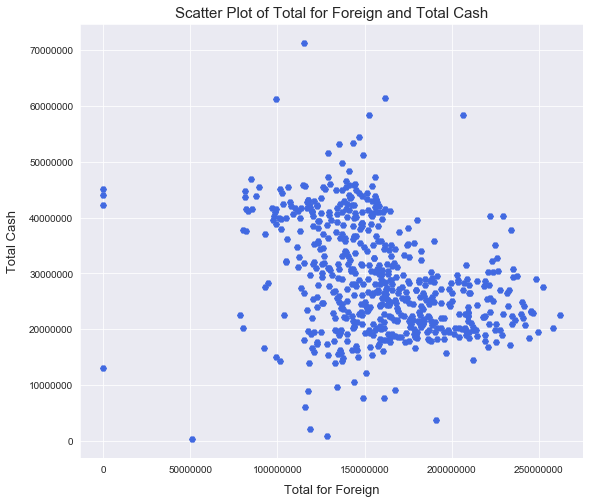

In [3]:
plt.figure(figsize=(9,8))
plt.scatter(x=auction_df['total_for_foreign'], 
            y=auction_df['total_cash'],
            c='royalblue',marker='H'
           )
plt.xlabel('Total for Foreign',labelpad=10,fontsize=13)
plt.ylabel('Total Cash',labelpad=10,fontsize=13)
plt.ticklabel_format(useOffset=False, style='plain')
plt.title('Scatter Plot of Total for Foreign and Total Cash',fontsize=15)
plt.show()

Just from plotting there are a number of points that appear anomalous.

#### Isolation Forest

In [4]:
# Normalize the data
X = auction_df[['total_for_foreign','total_cash']].dropna()
X_norm = preprocessing.normalize(X)

In [7]:
# Fit the model
clf = IsolationForest(max_samples=100,random_state=42)
clf.fit(X)

IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples=100, n_estimators=100,
                n_jobs=None, random_state=42, verbose=0, warm_start=False)

In [6]:
# 
df = X.copy(deep=True)
df['anomaly_scores'] = clf.decision_function(X)

auction_df.loc[auction_df.index.isin(df.index),'anomaly_scores'] = df['anomaly_scores']

In [ ]:
plt.figure(figsize=(15,5))
plt.hist(x=auction_df['anomaly_scores'].dropna(), 
         bins=60,
         color='royalblue'
        )
plt.title("Distribution of Anomaly Scores",fontsize=17)
plt.xlabel("Score",labelpad=10,fontsize=12)
plt.ylabel("Number of Datapoints",labelpad=10,fontsize=12)
plt.show()

In [ ]:
# Label the top 10th percentile of most anomalous datapoints
auction_df['most_anomalous'] = np.where(
    auction_df.anomaly_scores <= auction_df.anomaly_scores.quantile(.1),
    1,
    0
)

print(auction_df.most_anomalous.value_counts())

In [ ]:
markers = [".",'X']
sizes = [20, 60]
colors= ['royalblue','red']
plt.figure(figsize=(9,8))

for i in range(0,2):
    plt.scatter(
        auction_df[auction_df.most_anomalous==i]['total_for_foreign'], 
        auction_df[auction_df.most_anomalous==i]['total_cash'],
        s=sizes[i],
        marker=markers[i],
        c=colors[i]
    )
plt.title('Scatter Plot with Labels Overlayed',fontsize=15)
plt.xlabel('Total for Foreign',labelpad=10,fontsize=13)
plt.ylabel('Total Cash',labelpad=10,fontsize=13)
plt.legend(('Bottom 90% Least Anomalous','Top 10% Most Anomalous'), loc='upper right',fontsize=13)
plt.ticklabel_format(useOffset=False, style='plain')
plt.show()

In [ ]:
auction_df.sort_values(by='anomaly_scores')[:20]

In [ ]:
auction_df.total_cash.max()